# Import Libraries

In [1]:
from keras.datasets import mnist # subroutines for fetching the CIFAR-10 dataset
from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.core import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
%matplotlib inline

# Model Parameters

In [3]:
TESTING = True

In [4]:
batch_size = 128 # in each iteration, we consider 32 training examples at once

kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 512 neurons


num_epochs = 1 if TESTING else 10
fit_validation_split = 0.8 if TESTING else 0.1

## Architectures

In [5]:
arch_1 = ["conv_relu", "maxpool", "dropout"]
arch_2 = ["conv_relu", "maxpool", "dropout", "conv_relu", "maxpool", "dropout"]
arch_3 = ["conv_relu", "conv_relu", "maxpool", "dropout"]

full_architectures = [arch_1, arch_2, arch_3]
TESTING_architectures = [arch_1]

architectures = TESTING_architectures if TESTING else full_architectures

## Hyperparameters

### Conv2D hyper-parameters

In [6]:
kernel_sizes = [3, 5]

# Load Data

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch CIFAR-10 data

depth = 1
num_train, height, width = X_train.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= np.max(X_train) # Normalise data to [0, 1] range
X_test /= np.max(X_test) # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

### Reshape X data from (28, 28) to (28, 28, 1) for proper network feeding

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Setup Model

### Conv Unit

In [9]:
def add_conv_unit(conv_id, conv_depth, kernel_size):
    conv_layer = Convolution2D(conv_depth, 
                               (kernel_size, kernel_size), 
                               name=conv_id, 
                               padding='same', 
                               activation='relu')
    return conv_layer

### Pool Unit

In [10]:
def add_pool_unit():
    pool_layer = MaxPooling2D(pool_size=(pool_size, pool_size))
    return pool_layer

### Dropout Unit

In [11]:
def add_dropout_unit(drop_prob=0.2):
    dropout_layer = Dropout(drop_prob)
    return dropout_layer

# Setup Models

In [12]:
arch_dict = { "conv_relu" : add_conv_unit, "maxpool" : add_pool_unit, "dropout" : add_dropout_unit }

### Setup Model

In [13]:
def setup_model(architecture, kernel_size):
    
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    #                               FIXED
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    input_layer = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    
    prev_unit = input_layer
    conv_count = 0
    dropout_count = 0
    for layer_unit in architecture:
        print("\t\tLayer unit: {}".format(layer_unit))
        
        if layer_unit == "conv_relu":
            
            # Set conv_id for intermediate layer imaging post training
            conv_id = "conv_{}".format(conv_count)
            
            # Set conv depth
            conv_depth = conv_depth_1 if conv_count == 0 else conv_depth_2
            
            # Set new unit
            new_unit = arch_dict[layer_unit](conv_id, conv_depth, kernel_size)(prev_unit)
            
            # Increment conv count
            conv_count += 1
            
        elif layer_unit == "dropout":
            
            # Set dropout rate
            dropout_rate = drop_prob_1 if dropout_count == 0 else drop_prob_2
            
            # Set new unit
            new_unit = arch_dict[layer_unit](dropout_rate)(prev_unit)
            
            # Increment dropout count
            dropout_count += 1
            
        else:
            new_unit = arch_dict[layer_unit]()(prev_unit)
        
        prev_unit = new_unit
 
    
    
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    #                               FIXED
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    flat = Flatten()(prev_unit)
    hidden = Dense(hidden_size, activation='relu')(flat)
    drop_3 = Dropout(drop_prob_2)(hidden)
    out = Dense(num_classes, activation='softmax')(drop_3)
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    
    # Create model
    new_model = Model(inputs=input_layer, outputs=out) # To define a model, just specify its input and output layers
    
    # Compile model
    new_model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
                  optimizer='adam', # using the Adam optimiser
                  metrics=['accuracy']) # reporting the accuracy
    
    return new_model

In [14]:
models = []

for arch_i, arch in enumerate(architectures):
    print("Arch {}".format(arch_i))
    print("=======")
    for kernel_size in kernel_sizes:
        print("\tKernel Size: {}".format(kernel_size))
        print("\t---------------")
        new_model = setup_model(arch, kernel_size)
        print("\n")
        models.append(new_model)
    print("\n")

Arch 0
	Kernel Size: 3
	---------------
		Layer unit: conv_relu
		Layer unit: maxpool
		Layer unit: dropout


	Kernel Size: 5
	---------------
		Layer unit: conv_relu
		Layer unit: maxpool
		Layer unit: dropout






### Check Models

In [15]:
models

# Fit Models

#### Set Callbacks

In [16]:
def set_callbacks(model_number):
    MODEL_ARCH_FILEPATH = 'models/model_{0}/model{0}.json'.format(model_number)
    
    WEIGHTS_FILEDIR = "models/model_{}/weights".format(model_number)
    WEIGHTS_FILEPATH = WEIGHTS_FILEDIR + "weights-improvement-epoch_{epoch:02d}-acc_{val_acc:.2f}.hdf5"

    # Model saving callback
    checkpointer = ModelCheckpoint(filepath=WEIGHTS_FILEPATH, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

    # Early stopping 
    early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)
    
    return [checkpointer, early_stopping]

### Fit all models

In [17]:
for model_num, model in enumerate(models):
    callbacks = set_callbacks(model_num)
    model.fit(X_train, Y_train,                
                  batch_size=batch_size, epochs=num_epochs,
                  callbacks=callbacks,
                  verbose=1, validation_split=fit_validation_split)
    

Train on 11999 samples, validate on 48001 samples
Epoch 1/1
11999/11999 [==============================] - 15s - loss: 0.5099 - acc: 0.8454 - val_loss: 0.2339 - val_acc: 0.9294
Train on 11999 samples, validate on 48001 samples
Epoch 1/1
11999/11999 [==============================] - 20s - loss: 0.4770 - acc: 0.8622 - val_loss: 0.2085 - val_acc: 0.9377


# Evaluate Models

In [18]:
for model in models:
    loss, accr = model.evaluate(X_test, Y_test, verbose=1)  # Evaluate the trained model on the test set!`b

 9888/10000 [============================>.] - ETA: 0s

# Hidden Layer Visualization

In [19]:
layer_name = "conv_0"

model = models[0]

# model.get_config()

new_model = Model(inputs=model.input,
                  outputs=model.get_layer(layer_name).output)

In [20]:
new_model_out = new_model.predict(X_test)

# Plot Test Image

In [21]:
test_image_index = np.random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_index]

test_image = test_image.reshape(test_image.shape[0], test_image.shape[1])

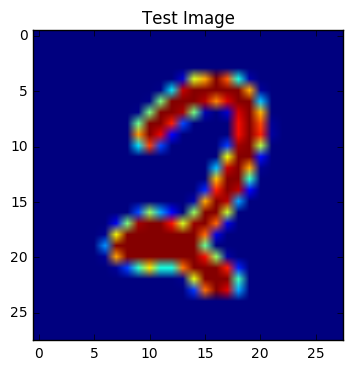

In [22]:
imshow = plt.imshow #alias
plt.title("Test Image")
imshow(test_image)

# Setup Hidden Layer Filters

In [23]:
conv_depth = conv_depth_1 if (layer_name == "conv_0" or layer_name == "conv_1") else conv_depth_2
filters = [new_model_out[test_image_index,:,:,filt_id] for filt_id in range(conv_depth)]

# Show Filters

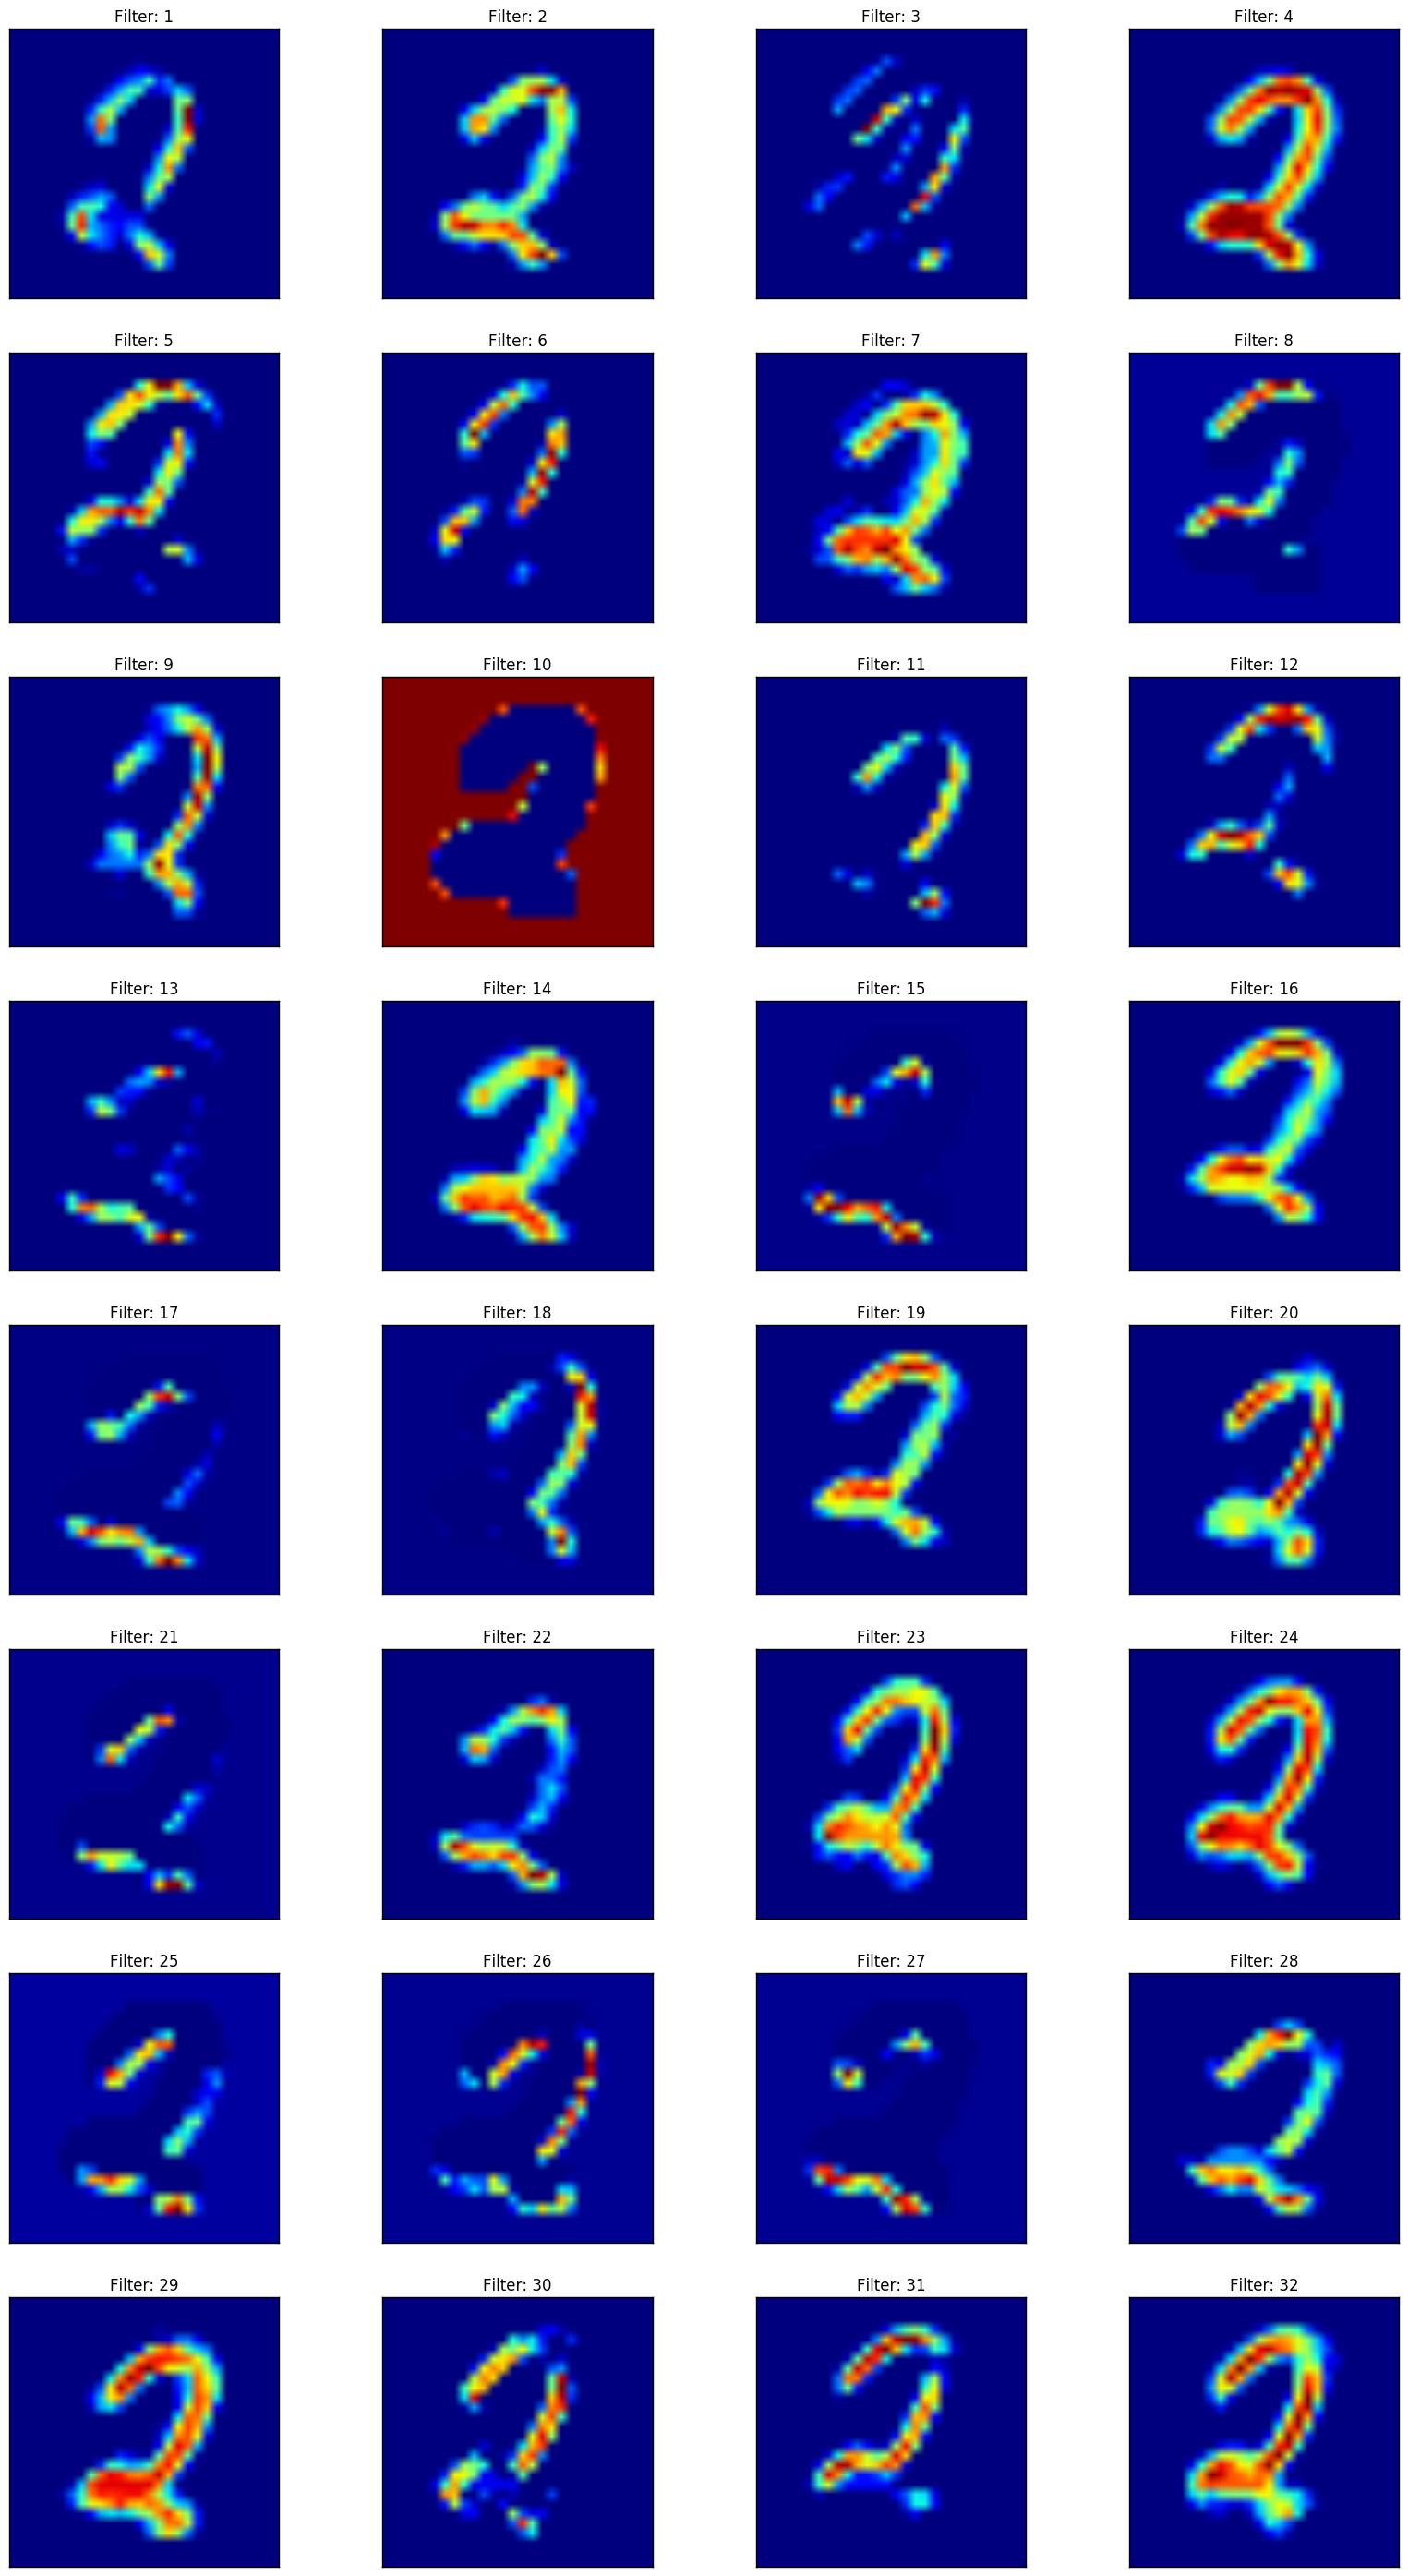

In [24]:
fig = plt.figure()

for i in range(conv_depth):
    filter_num = i+1
    ax = plt.subplot(conv_depth//4+1, 4, filter_num)
    
    imshow = plt.imshow #alias
    imshow(filters[i])
#     imshow(filters[i], cmap=plt.get_cmap('gray'))
    
    ax.set_title("Filter: {}".format(filter_num))
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.set_figwidth(20)
fig.set_figheight(40)

# References

https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer




https://github.com/fchollet/keras/issues/431

http://stackoverflow.com/questions/36745821/keras-1-0-getting-intermediate-layer-output/36789699#36789699

https://github.com/fchollet/keras/issues/2417

http://stackoverflow.com/questions/41911883/typeerror-tensor-object-is-not-callable